<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#动态图和静态图" data-toc-modified-id="动态图和静态图-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>动态图和静态图</a></span></li><li><span><a href="#JIT和核心概念" data-toc-modified-id="JIT和核心概念-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>JIT和核心概念</a></span></li><li><span><a href="#tracing-vs-script" data-toc-modified-id="tracing-vs-script-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>tracing vs script</a></span><ul class="toc-item"><li><span><a href="#torch.jit.trace" data-toc-modified-id="torch.jit.trace-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>torch.jit.trace</a></span></li><li><span><a href="#torch.jit.script" data-toc-modified-id="torch.jit.script-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>torch.jit.script</a></span></li></ul></li><li><span><a href="#参考" data-toc-modified-id="参考-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>参考</a></span></li></ul></div>

In [1]:
import torch

In [2]:
from torch import nn

pytorch为了提升模型的推理速度以及兼容torch模型在不同平台上运行，提出了pytorch模型的中间表示——TorchScript。当我们在将pytorch模型转换成onnx模型的过程时，pytorch模型其实首先被转换为了torch.jit.ScriptModule，在将TorchScript算子转换为onnx算子。

## 动态图和静态图

众所周知，我们在使用pytorch训练模型时是可以通过print或者log方式输出中间结果的，但是在TensorFlow中却做不到。这是因为pytorch是实时执行的，构造出来的模型使用的是动态图方式，而TensorFlow则是在一开始就把整个图构建好再运行，提供的是静态图方式。

由于动态图实时构建的特点，她并不适用于推理，但是静态图却适合，并且静态图可以通过多种方式进行优化从而提升推理性能。因此，pytorch为了提高推理速度提出了中间表示（Intermediate Representation, IR）TorchScript，它通过将动态图转换为静态图的方式达到以下几种优势：
+ TorchScript的代码可以通过它特有的解释器(PyTorch JIT Compiler)来加载和运行，这个解释器没有python中的GIL锁，从而可以支持多线程和多并发
+ 由于是中间表示，所以可以在其他非python环境上加载，如C++，或者其他非pytorch框架上运行
+ 原始静态图可以进一步优化从而提升推理速度

## JIT和核心概念

JIT是一个专门为TorchScript服务的解释器，它可以优化在python层定义的nn.Module模型，将其转换为TorchScript的模型并且运行。TorchScript既然是一种中间表示，肯定是有自己特有的表达方式的，类似于onnx中的protobuf，这个部分在后面可能会讲解到。但是，TorchScript在JIT中的核心概念其实是与python中的对应：
+ Module: 对应nn.Module，代表一个模块或者一个模型
+ Parameter: 对应nn.Parameters，代表模型参数（权重、偏置、embedding等）
+ Buffer：对应Tensor，用于模型训练过程中的数据记录，但是不参与梯度传播
+ Attribute：对应模型初始化时的配置，不会被保存到模型文件中
+ Method：模型的相关函数，比如forward
+ FunctionSchema：用于描述Method的输入和输出的类型、大小等属性
+ Graph：是Method中的代码（我觉得之所以把代码称为Graph，是因为这些代码使用的算子最终会成为静态图的节点并构成一个子图）。一个Graph由Block、Node和Value组成：
  - Block: 
  - Node:
  - Value: 

## tracing vs script

TorchScript提供两种方式将torch.nn.Module转换为ScriptModule：torch.jit.trace和torch.jit.script：
+ trace方式是根据输入将整个模型实际运行一遍，代码从python层解析到C++层中的具体算子，因此不支持控制流（if/while等语句）
+ script方式是在python层根据代码逻辑进行转换，支持控制流，但是却因为python语句的灵活性存在转换失败的可能
+ 在torch 2.x版本中逐渐转换为将TorchDynamo作为转换静态图的主要方式，即从模型的二进制文件中读取模型结构

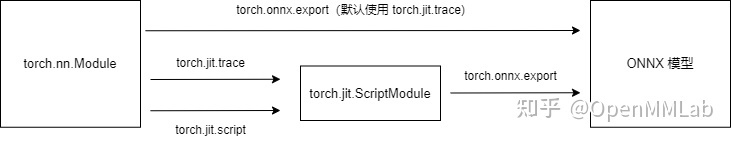

In [20]:
class CondModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        if torch.sum(x) > 10:
            return x
        else:
            return x + 10

torch_model = CondModel()
input_x = torch.rand(2, 3)

### torch.jit.trace

In [21]:
trace_model = torch.jit.trace(torch_model, input_x)

/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  


In [22]:
trace_model.graph

graph(%self : __torch__.___torch_mangle_3.CondModel,
      %x : Float(2, 3, strides=[3, 1], requires_grad=0, device=cpu)):
  %8 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/3381973082.py:9:0
  %9 : int = prim::Constant[value=1]() # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/3381973082.py:9:0
  %10 : Float(2, 3, strides=[3, 1], requires_grad=0, device=cpu) = aten::add(%x, %8, %9) # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/3381973082.py:9:0
  return (%10)

使用model.graph可以查到生成的静态图，但这是底层的表示方法难以看懂，可以使用model.code方式查看：

In [23]:
print(trace_model.code)

def forward(self,
    x: Tensor) -> Tensor:
  return torch.add(x, CONSTANTS.c0)



In [7]:
model.graph

graph(%self : __torch__.CondModel,
      %x : Float(2, 3, strides=[3, 1], requires_grad=0, device=cpu)):
  %8 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/4284957722.py:9:0
  %9 : int = prim::Constant[value=1]() # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/4284957722.py:9:0
  %10 : Float(2, 3, strides=[3, 1], requires_grad=0, device=cpu) = aten::add(%x, %8, %9) # /var/folders/3p/mvrxlkq16dlfhgxbl9f31bvh0000gn/T/ipykernel_2299/4284957722.py:9:0
  return (%10)

可以观察到生成的ScriptModel中缺少了条件判断语句，直接返回输入和10的结果。可以比较一下两个模型的输出：

In [24]:
torch_model(input_x), trace_model(input_x)

(tensor([[10.3035, 10.4609, 10.7085],
         [10.6423, 10.9892, 10.7417]]),
 tensor([[10.3035, 10.4609, 10.7085],
         [10.6423, 10.9892, 10.7417]]))

结果是一致的。但是当我们更换一个输入时结果却不相同：

In [27]:
input_y = torch.ones(2, 3) * 5
torch_model(input_y), trace_model(input_y)

(tensor([[5., 5., 5.],
         [5., 5., 5.]]),
 tensor([[15., 15., 15.],
         [15., 15., 15.]]))

In [36]:
trace_model.__class__

torch.jit._trace.TopLevelTracedModule

### torch.jit.script

In [28]:
script_model = torch.jit.script(torch_model)

In [30]:
print(script_model.code)

def forward(self,
    x: Tensor) -> Tensor:
  if bool(torch.gt(torch.sum(x), 10)):
    _0 = x
  else:
    _0 = torch.add(x, 10)
  return _0



可以看到script方式保留了条件判断语句，所以得到的结果会与torch_model完全一致。

In [31]:
torch_model(input_x), script_model(input_x)

(tensor([[10.3035, 10.4609, 10.7085],
         [10.6423, 10.9892, 10.7417]]),
 tensor([[10.3035, 10.4609, 10.7085],
         [10.6423, 10.9892, 10.7417]]))

In [32]:
torch_model(input_y), script_model(input_y)

(tensor([[5., 5., 5.],
         [5., 5., 5.]]),
 tensor([[5., 5., 5.],
         [5., 5., 5.]]))

In [37]:
script_model.__class__

torch.jit._script.RecursiveScriptModule

关于这两种方式的底层源代码调用逻辑可以参考[]()

## 参考

+ TorchScript介绍：https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html
+ C++运行ScriptModule： https://pytorch.org/tutorials/advanced/cpp_export.html
+ pytorch转换为onnx: https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
+ openmmlab的TorchScript系列文章：https://zhuanlan.zhihu.com/p/486914187

In [35]:
list(torch_model.named_children())

[]